In [ ]:
import torch
import umap
import numpy as np
import matplotlib.pyplot as plt

In [8]:
from hubersed.style import *
from hubersed.paths import PATHS

DATA_PATH = PATHS['DATA']
RESULTS_PATH = PATHS['RESULTS']

In [3]:
device = torch.device('cpu')

In [5]:
latent_space_dict = torch.load(DATA_PATH / 'desi_noise_spender_10latent_space.pt', map_location=device)

In [6]:
latents = latent_space_dict['latents']

A = latent_space_dict['A']
A = A.squeeze()

z = latent_space_dict['zs']

In [7]:
reducer = umap.UMAP(random_state=42, n_neighbors=5).fit(latents)

/Users/ng27753/Astronomy_Research/hubersed/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [9]:
embeddings = reducer.transform(latents)

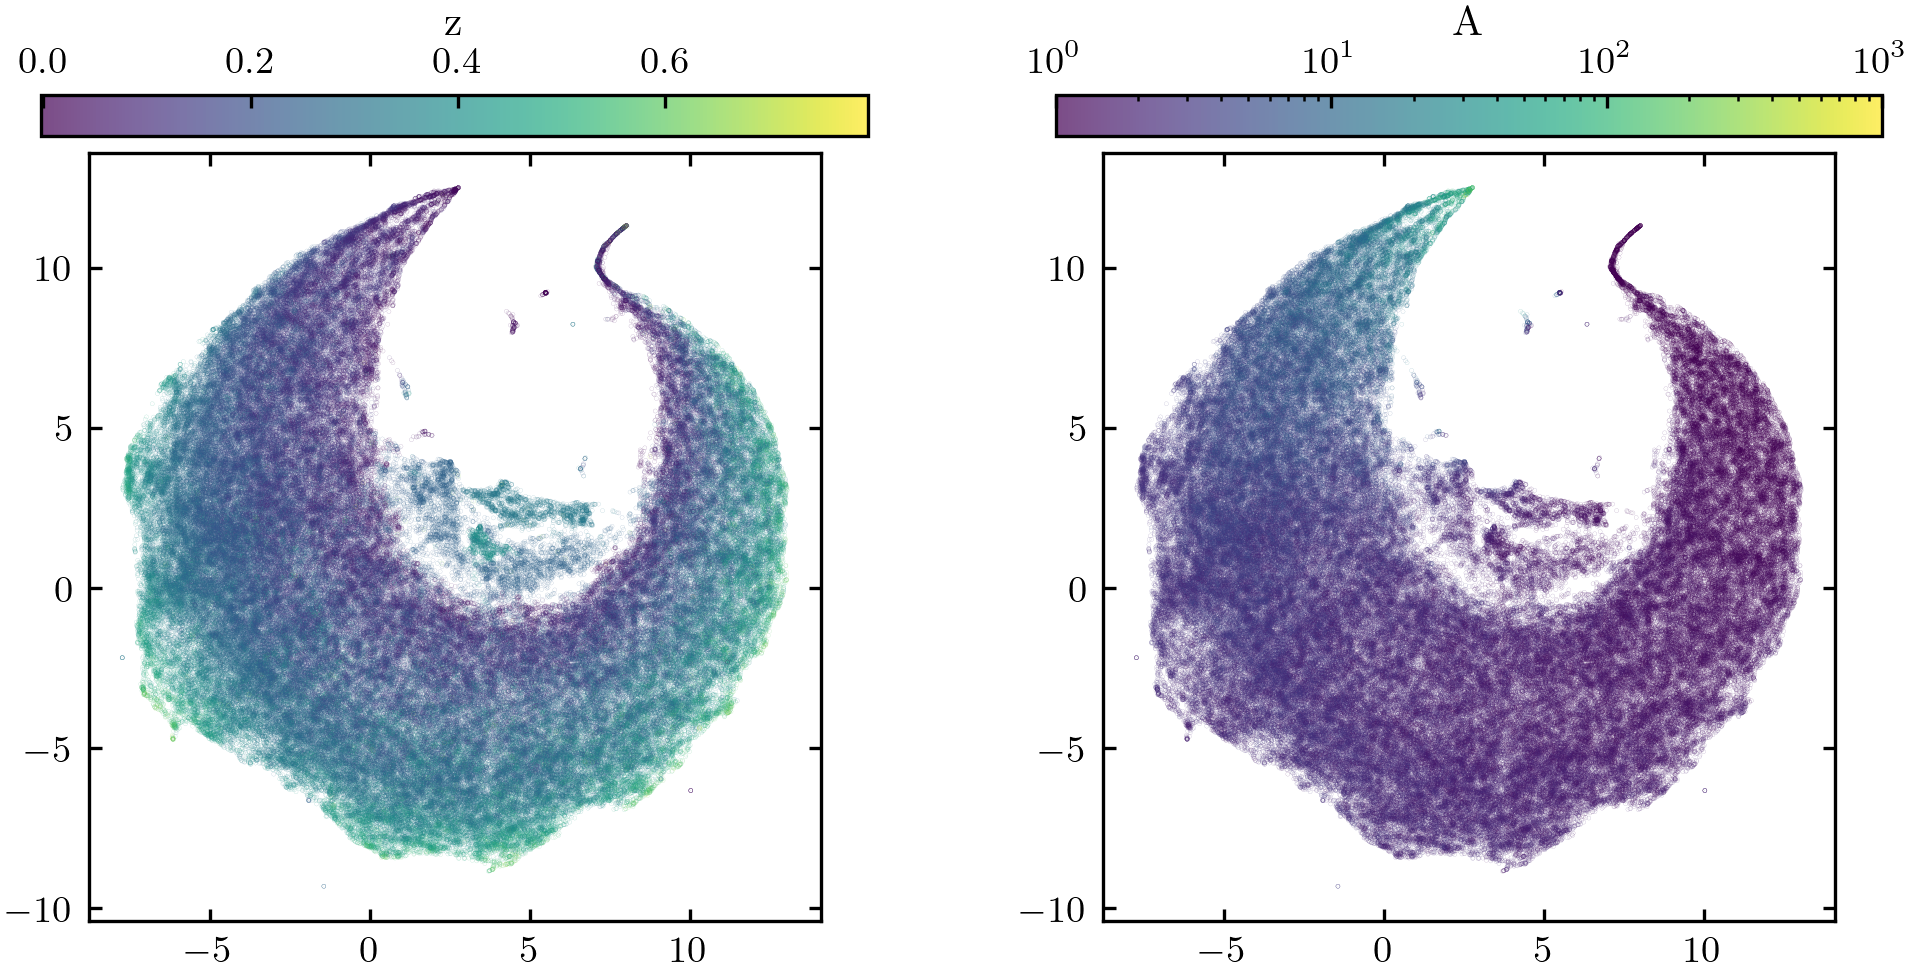

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(7., 3.5), dpi=300)
ax = ax.ravel()

# both ax should be equal aspect
for a in ax:
    a.set_aspect('equal', 'box')

scatter = ax[0].scatter(
    embeddings[:, 0], embeddings[:, 1],
    c=z, cmap='viridis',
    s=0.005, alpha=0.7,
    rasterized=True,
    marker='.'
)

# colorbar on top
cbar = fig.colorbar(
    scatter,
    ax=ax[0],
    orientation='horizontal',
    pad=0.02,          # distance between plot and colorbar
    fraction=0.05,     # thickness of colorbar
    location='top'
)


cbar.set_label('z')

import matplotlib as mpl
norm = mpl.colors.LogNorm(vmin=1, vmax=1000)
cmap = mpl.cm.ScalarMappable(norm=norm, cmap='viridis')
scatter.set_cmap(cmap.cmap)

scatter = ax[1].scatter(embeddings[:, 0], embeddings[:, 1], c=A, s=.005, alpha=0.7, norm=norm, rasterized=True, marker='.')

cbar = plt.colorbar(scatter, ax=ax[1], orientation='horizontal', pad=0.02, fraction=0.05, location='top')
cbar.set_label('A')

fig.tight_layout()

fig.savefig(RESULTS_PATH / 'desi_noise_spender_10latent_space_umap.pdf', dpi=300)
